Импортирую библиотеки

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/Yuichir0/Telecom/tree/main/thinkdsp.py
from thinkdsp import decorate, SinSignal, Chirp, normalize, unbias, read_wave

### Упражнение 3.1
Запустите и прослушайте примеры из блокнота chap03.ipynb.

В примере с утечкой замените окно Хэмминга одним из окон, предоставляемых NumPy, и посмотрите, как они влияют на утечle:

### Решение

Создам сигнал с утечкой

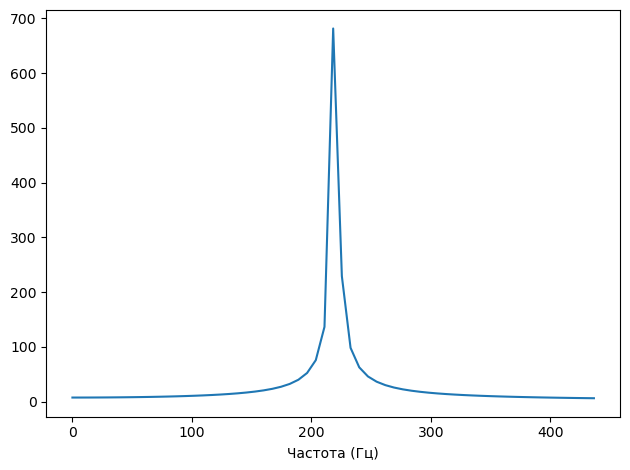

In [2]:
signal = SinSignal(freq=220)
duration = signal.period * 30.25
wave = signal.make_wave(duration)
spectrum = wave.make_spectrum()
spectrum.plot(high=440)
decorate(xlabel='Частота (Гц)')

Воспользуюсь функцией NumPy для применения 4 фильтров

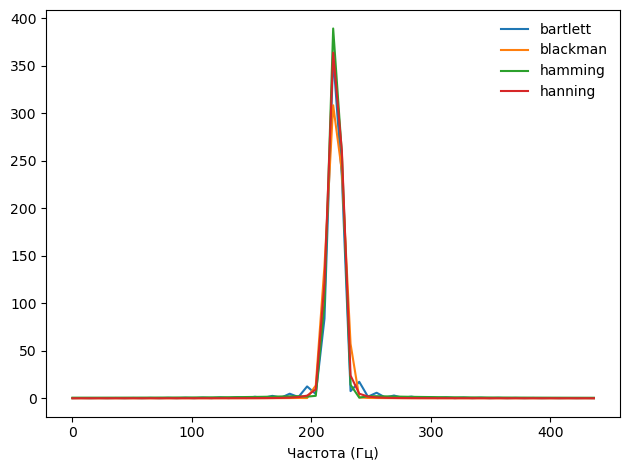

In [3]:
for window_func in [np.bartlett, np.blackman, np.hamming, np.hanning]:
    wave = signal.make_wave(duration)
    wave.ys *= window_func(len(wave.ys))

    spectrum = wave.make_spectrum()
    spectrum.plot(high=440, label=window_func.__name__)

decorate(xlabel='Частота (Гц)')

Все фильтры хорошо справились с уменьшением утечки. У фильтра Барлетта можно заметить немного шума, когда у фильтра Ханнинга получился самый чистый результат

### Упражнение 3.2
Напишите класс, называемый SawtoothChirp, расширающий Chirp и переопределяющий evaluate для генерации пилообразного сигнала с линейно увеличивающейся (или уменьшающейся) частотой.

Подсказка: надо совместить функции evaluate из Chirp и SawtoothSignal.

Нарисуйте эскиз спектрограммы этого сигнала, а затем распечатайте ее. Эффект биений должен быть очевиден, а если сигнал внимательно прослушать, то биения можно и услышать.

In [4]:
class SawtoothChirp(Chirp):
    def evaluate(self, ts):
        freqs = np.linspace(self.start, self.end, len(ts))
        dts = np.diff(ts, prepend=0)
        dphis = 2 * np.pi * freqs * dts
        phases = np.cumsum(dphis)
        cycles = phases / (2 * np.pi)
        frac, _ = np.modf(cycles)
        ys =  normalize(unbias(frac), self.amp)
        return ys

Проверю функцию, сгенерировав аудио и спектрограмму

In [5]:
signal = SawtoothChirp(start=440, end=880)
wave = signal.make_wave(duration=1, framerate=4000)
wave.apodize()
wave.make_audio()

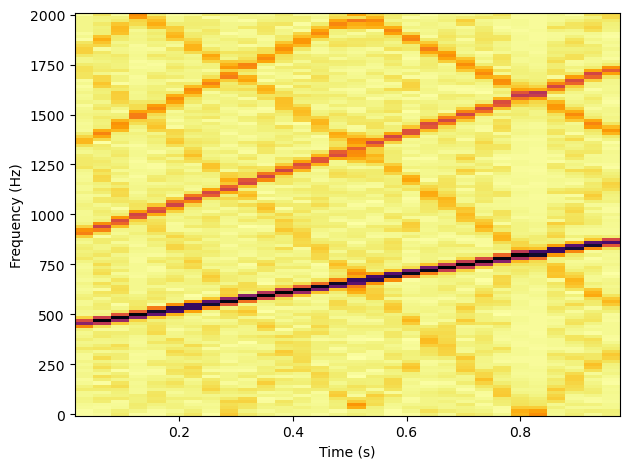

In [6]:
sp = wave.make_spectrogram(256)
sp.plot()
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

Основная частота имеет более темный цвет, видно и слышно, как остальные бьются 

### Упражнение 3.3
Создайте пилообразный чирп, меняющийся от 2500 до 3000 Гц, и на его основе сгенерируйте сигнал длительностью 1 сек. и с частотой 20 кГц. Нарисуйте, каким примерно будет Spectrum. Затем распечатайте Spectrum и посмотрите, правы ли вы.

### Решение

Создам сигнал по заданию

In [7]:
signal = SawtoothChirp(start=2500, end=3000)
wave = signal.make_wave(duration=1, framerate=20000)
wave.make_audio()

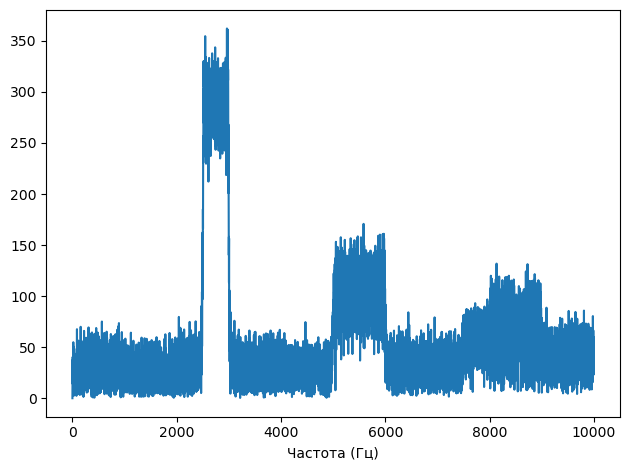

In [8]:
wave.make_spectrum().plot()
decorate(xlabel='Частота (Гц)')

На waveform-е видно, как на частоте 2500-3000 имеется пик, далее гармоники на частоте около 5000-6000 и 7500-9000

### Упражнение 3.4
В музыкальной терминалогии глиссандо - это нота, меняющаяся от одной высоты до другой, то есть своеобразный чирп.

Найдите или запишите звук глиссандо и распечатайте спектрограмму первых нескольких секун
Рекомендуемый в учебнике звук нельзя скачать в форматах файла, принимаемых методом wave, поэтому воспользуюсь примером из учебника24.

In [9]:
if not os.path.exists('72475__rockwehrmann__glissup02.wav'):
    !wget https://github.com/Yuichir0/Telecom72475__rockwehrmann__glissup02.wav

In [10]:
wave = read_wave('72475__rockwehrmann__glissup02.wav')
wave.make_audio()

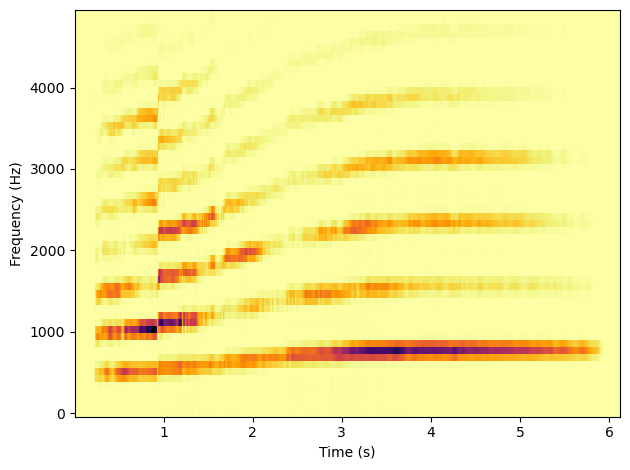

In [11]:
wave.make_spectrogram(512).plot(high=5000)
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

Видно, что глиссандо похоже на синтезированный чирп

### Exercise 5

A trombone player can play a glissando by extending the trombone slide while blowing continuously. As the slide extends, the total length of the tube gets longer, and the resulting pitch is inversely proportional to length.
Assuming that the player moves the slide at a constant speed, how
does frequency vary with time?  

Write a class called `TromboneGliss` that extends `Chirp` and
provides `evaluate`.  Make a wave that simulates a trombone
glissando from F3 down to C3 and back up to F3.  C3 is 262 Hz; F3 is
349 Hz.

Plot a spectrogram of the resulting wave.  Is a trombone glissando
more like a linear or exponential chirp?

### Решение
Напишу класс и метод по заданию

In [12]:
class TromboneGliss(Chirp):
    def evaluate(self, ts):
        l1, l2 = 1.0 / self.start, 1.0 / self.end
        lengths = np.linspace(l1, l2, len(ts))
        freqs = 1 / lengths
        dts = np.diff(ts, prepend=0)
        dphis = 2 * np.pi * freqs * dts
        phases = np.cumsum(dphis)
        ys = self.amp * np.cos(phases)
        return ys

Напишу 2 сигнала и после соединю их

In [13]:
low = 262
high = 349
signal = TromboneGliss(low, high)
wave1 = signal.make_wave(duration=1)
wave1.apodize()
wave1.make_audio()

In [14]:
signal = TromboneGliss(high, low)
wave2 = signal.make_wave(duration=1)
wave2.apodize()
wave2.make_audio()

In [15]:
wave = wave1 | wave2
wave.make_audio()

Получившаяся спектрограмма

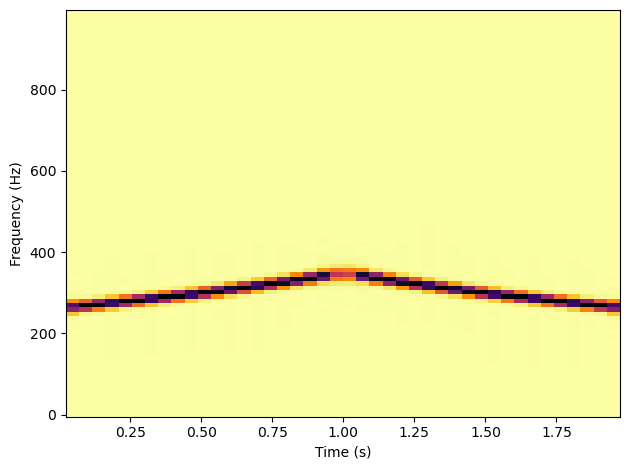

In [16]:
sp = wave.make_spectrogram(1024)
sp.plot(high=1000)
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

### Упражнение 3.6
Сделайте или найдите запись серии гласных звуков и посмотрите на спектрограмму. Сможете ли вы различить разные глссные
Запишу и загружу звуки "а" и "о"?

In [20]:
if not os.path.exists('AaaOoo.wav'):
    !wget https://github.com/Yuichir0/Telecom/AaaOoo.wav
wave = read_wave('AaaOoo.wav')
wave.make_audio()

In [ ]:
Построю спектрограмму этих глассных:

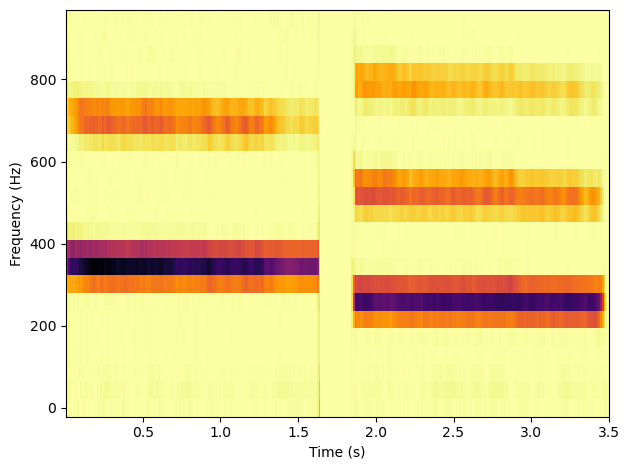

In [21]:
wave.make_spectrogram(1024).plot(high=1000)
decorate(xlabel='Время (с)', ylabel='Частота (Гц)')

По этой спектрограмме нельзя различить гласные, построю более детальные спектрограммы 

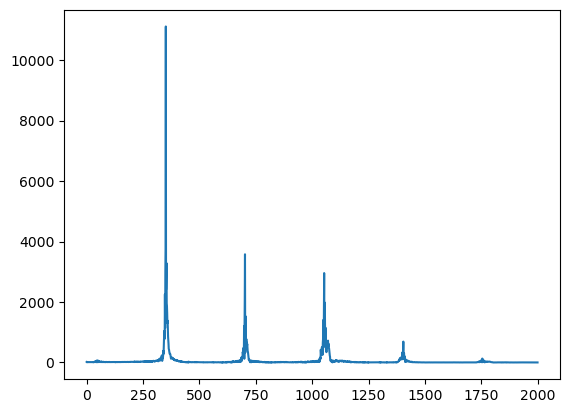

In [23]:
segment = wave.segment(start=0, duration=1)
segment.make_spectrum().plot(high=2000)

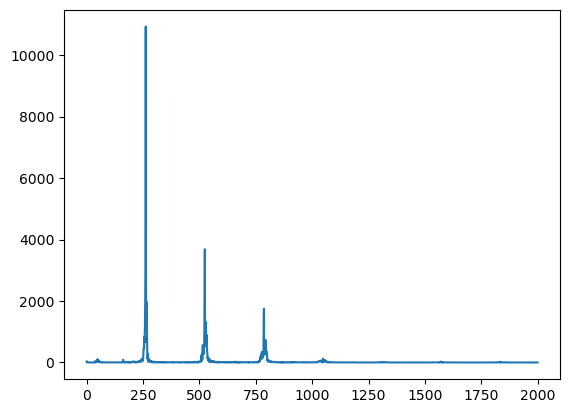

In [24]:
segment = wave.segment(start=2, duration=1)
segment.make_spectrum().plot(high=2000)

Можно заметить, что у гласной "о" спектрограмма затухает быстрее - имеет меньше высоких гармоник